In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import logging
from scipy.optimize import curve_fit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from joblib import Parallel, delayed
from dask.distributed import Client
import dask
import gc
import warnings
from pmdarima.arima import ndiffs, nsdiffs
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pmdarima as pm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from datetime import datetime 
import joblib

In [4]:
# Define start and end date
start_date = '2015-01-01 00:00:00'
end_date = '2023-12-31 23:59:59'

# Function to prepare datasets
def prepare_dataset(df, start_date, end_date):
    # Create a copy of the DataFrame
    df = df.copy()
    
    # Convert Timestamp to datetime and set as index
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M:%S')
    df.set_index('Timestamp', inplace=True)
    
    # Slice the time period right after setting the index
    df = df[start_date:end_date].copy()
    
    # Remove timestamp duplicates (keep the first entry)
    df = df[~df.index.duplicated(keep='first')]
    
    # Convert all numeric columns to float
    for column in df.select_dtypes(include=['object']).columns:
        try:
            df.loc[:, column] = df[column].astype(float)
        except ValueError:
            print(f"Could not convert column {column} to float")
    
    return df

# Import and prepare the datasets
air_quality = pd.read_csv('dataset/Veenkampen_Air Quality.csv', skiprows=[1])
air_quality = prepare_dataset(air_quality, start_date, end_date)

meteorology = pd.read_csv('dataset/Veenkampen_Meteorology.csv', skiprows=[1])
meteorology = prepare_dataset(meteorology, start_date, end_date)

soil = pd.read_csv('dataset/Veenkampen_Soil.csv', skiprows=[1])
soil = prepare_dataset(soil, start_date, end_date)

# Import and prepare the flux dataset
fluxes = pd.read_csv('./dataset/Veenkampen_Fluxes.csv', skiprows=[1]) # Remove units row
fluxes = prepare_dataset(fluxes, start_date, end_date)

# Show information about all prepared datasets
print("\nTime range of datasets:")
for name, df in [("Air Quality", air_quality), ("Meteorology", meteorology), 
                 ("Soil", soil), ("Fluxes", fluxes)]:
    print(f"\n{name}:")
    print(f"Start: {df.index.min()}")
    print(f"End: {df.index.max()}")
    print(f"Number of data points: {len(df)}")

# Show dataset info
print("\nDataset Infos:")
for name, df in [("Air Quality", air_quality), ("Meteorology", meteorology), 
                 ("Soil", soil), ("Fluxes", fluxes)]:
    print(f"\n{name} Dataset Info:")
    print(df.info())

# Check for missing values
print("\nMissing values:")
for name, df in [("Air Quality", air_quality), ("Meteorology", meteorology), 
                 ("Soil", soil), ("Fluxes", fluxes)]:
    print(f"\nMissing values in {name}:")
    print(df.isnull().sum())

# Check sampling rates
print("\nSampling intervals:")
for name, df in [("Air Quality", air_quality), ("Meteorology", meteorology), 
                 ("Soil", soil), ("Fluxes", fluxes)]:
    print(f"\n{name}:")
    print(df.index.to_series().diff().value_counts().head())


Time range of datasets:

Air Quality:
Start: 2015-01-01 00:00:00
End: 2023-12-31 23:56:00
Number of data points: 979527

Meteorology:
Start: 2015-01-01 00:00:00
End: 2023-12-31 23:59:00
Number of data points: 4720489

Soil:
Start: 2015-01-01 00:00:00
End: 2023-12-31 23:59:00
Number of data points: 4717918

Fluxes:
Start: 2015-01-01 00:00:00
End: 2023-12-31 23:30:00
Number of data points: 140422

Dataset Infos:

Air Quality Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 979527 entries, 2015-01-01 00:00:00 to 2023-12-31 23:56:00
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   co2_mixing_ratio  130219 non-null  float64
 1   h2o_mixing_ratio  140145 non-null  float64
 2   BC                362135 non-null  float64
 3   NOx               646041 non-null  float64
 4   NO                646041 non-null  float64
 5   NO2               646041 non-null  float64
 6   O3                628638

In [5]:
# Load dataset (Ensure the correct data path is used)
data = fluxes['co2_flux'].copy()

# 1. Basic descriptive analysis of CO2 flux values
print("=== Descriptive Statistics ===")
print(data.describe())

# 2. Outlier detection using the Interquartile Range (IQR) method
# The IQR method is a robust statistical approach to identify potential outliers by assessing the data spread between the first (Q1) and third quartiles (Q3).
q1, q3 = data.quantile([0.25, 0.75])
iqr = q3 - q1
iqr_low = q1 - 1.5 * iqr  # Lower bound for moderate outliers
iqr_high = q3 + 1.5 * iqr  # Upper bound for moderate outliers

print(f"\nIQR-based thresholds: [{iqr_low:.2f}, {iqr_high:.2f}] µmol/m²/s")

# 3. Defining alternative thresholds using the 5th and 95th percentiles
# The 95% confidence interval captures the central distribution of the data, reducing the influence of extreme values.
p05, p95 = data.quantile([0.05, 0.95])
print(f"\n95% range: [{p05:.2f}, {p95:.2f}] µmol/m²/s")

# 4. Justification for threshold selection
# The IQR method is highly effective for detecting moderate outliers but may exclude valid extreme observations in dynamic natural systems.
# The 95% percentile approach is more flexible, preserving a broader range of natural variation while filtering extreme anomalies.
# For conservative outlier removal, IQR is recommended.
# For a more inclusive approach that retains natural variability, the 95% range is preferable.

# 5. Data cleaning using both methods

# Approach 1: IQR-based filtering
clean_data_iqr = data.where(
    (data >= iqr_low) & 
    (data <= iqr_high)
)

# Approach 2: 95%-based filtering
clean_data_95 = data.where(
    (data >= p05) & 
    (data <= p95)
)

# Compare data retention after filtering
print(f"\nRemaining data after filtering (IQR applied): {clean_data_iqr.count() / len(data):.1%}")
print(f"Remaining data after filtering (95% range applied): {clean_data_95.count() / len(data):.1%}")

=== Descriptive Statistics ===
count    1.302190e+05
mean     6.126728e+06
std      1.579221e+09
min     -5.072780e+02
25%     -5.093183e+00
50%      5.899440e-01
75%      3.217230e+00
max      4.559529e+11
Name: co2_flux, dtype: float64

IQR-based thresholds: [-17.56, 15.68] µmol/m²/s

95% range: [-14.81, 11.78] µmol/m²/s

Remaining data after filtering (IQR applied): 86.2%
Remaining data after filtering (95% range applied): 83.5%


## Interpolation of missing values in the CO2 flux data

Statistics of cleaned co2_flux (outliers removed):
count    117194.000000
mean         -0.718166
std           5.479319
min         -14.799859
25%          -4.354316
50%           0.591012
75%           2.861450
max          11.798248
Name: co2_flux_clean, dtype: float64


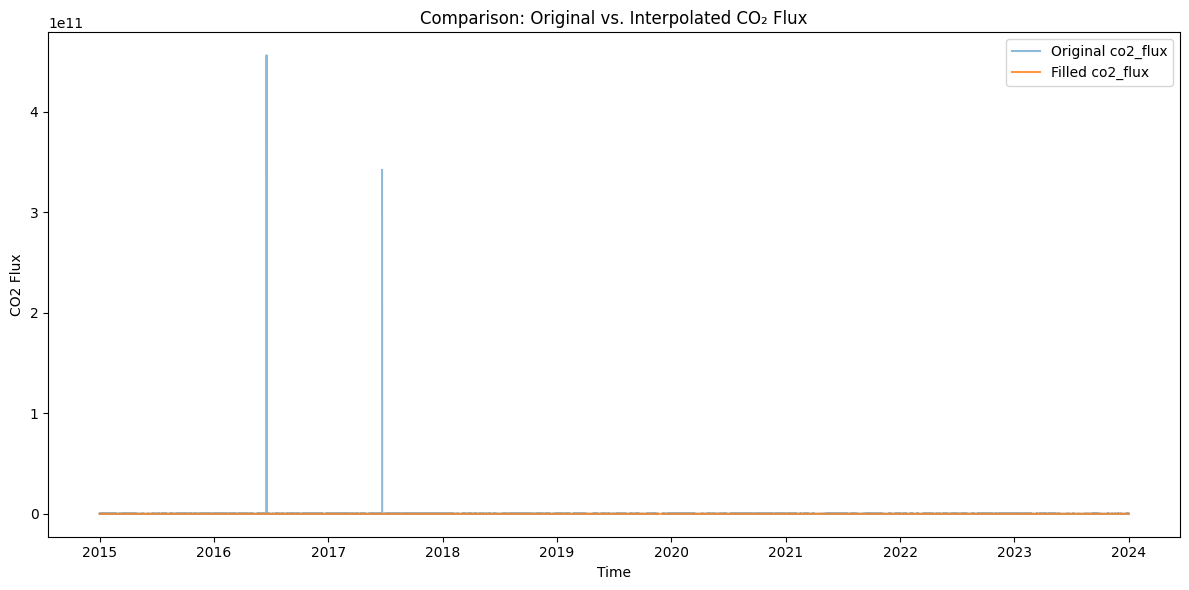


Statistics of filled co2_flux:
count    140422.000000
mean         -0.683190
std           5.534503
min         -14.799859
25%          -4.307255
50%           0.640778
75%           2.934627
max          11.798248
Name: co2_flux_filled, dtype: float64


In [6]:
# Set the random seed for reproducibility
np.random.seed(42)

# Assumption: The datasets (air_quality, meteorology, soil, fluxes) are already imported and prepared.

# ---------------------------------
# 0. Preparation: Interpolation of solar radiation data
# ---------------------------------
# The variable SW_IN_1_1_1 from the meteorology dataset is used for day/night determination.
# Interpolate missing values in SW_IN_1_1_1 using time-based interpolation.
meteorology['SW_IN_1_1_1'] = meteorology['SW_IN_1_1_1'].interpolate(method='time', limit_direction='both')

# To align solar radiation data with flux timestamps, reindex the meteorological SW_IN values 
# to match the flux dataset's time grid using the nearest method, as meteorological data is at 1-minute intervals.
flux_df = fluxes.copy()
flux_df['SW_IN'] = meteorology['SW_IN_1_1_1'].reindex(flux_df.index, method='nearest')

# ---------------------------------
# 1. Statistical analysis and outlier removal of CO₂ flux data
# ---------------------------------
# Copy the original CO₂ flux data into a new column
flux_df['co2_flux_clean'] = flux_df['co2_flux'].copy()

# Set values outside the 95% range (less than -14.8 or greater than 11.8) as outliers to NaN
flux_df.loc[(flux_df['co2_flux_clean'] < -14.8) | (flux_df['co2_flux_clean'] > 11.8), 'co2_flux_clean'] = np.nan

print("Statistics of cleaned co2_flux (outliers removed):")
print(flux_df['co2_flux_clean'].describe())

# ---------------------------------
# 2. Preparation for interpolation: Differentiating between short and long gaps
# ---------------------------------
# Determine the typical sampling interval in hours (median of time differences)
median_interval = flux_df.index.to_series().diff().median().total_seconds() / 3600.0

# Perform an initial linear time interpolation to fill all gaps
flux_df['co2_flux_lin'] = flux_df['co2_flux_clean'].interpolate(method='time', limit_direction='both')

# Identify indices of gaps longer than 1.5 hours
na_mask = flux_df['co2_flux_clean'].isna()
group_ids = (na_mask != na_mask.shift()).cumsum()
missing_groups = flux_df[na_mask].groupby(group_ids)

long_gap_indices = []
for group_id, group in missing_groups:
    # Compute the gap duration (difference between first and last timestamp plus one typical interval)
    gap_duration = (group.index[-1] - group.index[0]).total_seconds() / 3600.0 + median_interval
    if gap_duration > 1.5:
        long_gap_indices.extend(group.index)

# Reset values in the linearly interpolated series to NaN for long gaps
flux_df.loc[long_gap_indices, 'co2_flux_lin'] = np.nan

# ---------------------------------
# 3. Definition of day/night determination using solar radiation
# ---------------------------------
# Daytime is assumed when SW_IN > 20 W/m², otherwise, it is considered nighttime.
def is_day(timestamp):
    # Use the interpolated SW_IN value from the flux dataset for the given timestamp.
    # If the value is missing, default to nighttime.
    sw_value = flux_df.at[timestamp, 'SW_IN'] if pd.notnull(flux_df.at[timestamp, 'SW_IN']) else 0
    return sw_value > 20

# ---------------------------------
# 4. Gap filling using Marginal Distribution Sampling (MDS)
# ---------------------------------
# For each timestamp in long gaps, a random value is drawn from the empirical distribution of cleaned CO₂ flux data,
# based on whether it is day or night.
for ts in long_gap_indices:
    if is_day(ts):
        # Select all valid values in the daytime period (SW_IN > 5)
        pool = flux_df.loc[flux_df['SW_IN'] > 2, 'co2_flux_clean'].dropna()
    else:
        # Select all valid values in the nighttime period (SW_IN <= 5)
        pool = flux_df.loc[flux_df['SW_IN'] <= 2, 'co2_flux_clean'].dropna()
    
    if len(pool) > 0:
        flux_df.at[ts, 'co2_flux_lin'] = np.random.choice(pool.values)
    else:
        flux_df.at[ts, 'co2_flux_lin'] = np.nan

# The combined result (linear interpolation for short gaps, MDS for long gaps) 
# is stored in the column 'co2_flux_filled'.
flux_df['co2_flux_filled'] = flux_df['co2_flux_lin']

# ---------------------------------
# 5. Interpolation of external variables in the flux dataset
# ---------------------------------
# Perform a simple time interpolation for all other variables with missing values.
cols_to_exclude = ['co2_flux', 'co2_flux_clean', 'co2_flux_lin', 'co2_flux_filled', 'SW_IN']
external_cols = [col for col in flux_df.columns if col not in cols_to_exclude]

if external_cols:
    flux_df[external_cols] = flux_df[external_cols].interpolate(method='time', limit_direction='both')

# ---------------------------------
# 6. Visualization and final statistics
# ---------------------------------
plt.figure(figsize=(12, 6))
plt.plot(flux_df.index, flux_df['co2_flux'], label='Original co2_flux', alpha=0.5)
plt.plot(flux_df.index, flux_df['co2_flux_filled'], label='Filled co2_flux', alpha=0.8)
plt.xlabel("Time")
plt.ylabel("CO2 Flux")
plt.title("Comparison: Original vs. Interpolated CO₂ Flux")
plt.legend()
plt.tight_layout()
plt.show()

print("\nStatistics of filled co2_flux:")
print(flux_df['co2_flux_filled'].describe())


## Fill gaps in the dataset after CO2 flux interpolation

In [7]:
import numpy as np
import pandas as pd
import logging

# Logging configuration
logging.basicConfig(
    filename='gap_filling.log', 
    level=logging.DEBUG, 
    format='%(asctime)s - %(levelname)s - %(message)s', 
    filemode='a'
)
logger = logging.getLogger()

def fill_gaps_mds(df, col_original, condition_pool_func, gap_threshold_hours=1.5):
    """
    Fills gaps in a time series based on linear interpolation and MDS for long gaps.
    """
    missing_before = df[col_original].isna().sum()
    logger.info(f"{col_original}: Missing values before interpolation: {missing_before}")
    
    col_lin = col_original + '_lin'
    col_filled = col_original + '_filled'
    df[col_lin] = df[col_original].interpolate(method='time', limit_direction='both')
    
    na_mask = df[col_original].isna()
    group_ids = (na_mask != na_mask.shift()).cumsum()
    missing_groups = df[na_mask].groupby(group_ids)
    
    median_interval = df.index.to_series().diff().median().total_seconds() / 3600.0
    long_gap_indices = []
    for group_id, group in missing_groups:
        gap_duration = (group.index[-1] - group.index[0]).total_seconds() / 3600.0 + median_interval
        if gap_duration > gap_threshold_hours:
            long_gap_indices.extend(group.index)
    
    df.loc[long_gap_indices, col_lin] = np.nan
    
    for ts in long_gap_indices:
        pool = condition_pool_func(df, ts, col_original)
        if len(pool) > 0:
            df.at[ts, col_lin] = np.random.choice(pool.values)
        else:
            df.at[ts, col_lin] = np.nan
    
    df[col_filled] = df[col_lin]
    
    missing_after = df[col_filled].isna().sum()
    logger.info(f"{col_filled}: Missing values after gap filling: {missing_after}")
    
    return df

def meteo_pool(df, ts, col_original):
    current_hour = ts.hour
    pool = df[df.index.hour == current_hour][col_original].dropna()
    if pool.empty:
        pool = df[col_original].dropna()
    return pool

# Determine the relevant datasets for interpolation
meteorology = meteorology if 'meteorology' in locals() else None
soil = soil if 'soil' in locals() else None
flux_df = flux_df if 'flux_df' in locals() else None

datasets = {'meteorology': meteorology,
            'soil': soil,
            }

# Apply interpolation to relevant variables and add them to flux_df
for dataset_name, dataset in datasets.items():
    if dataset is not None:
        if dataset_name == 'meteorology':
            target_cols = ['TA_1_1_1', 'RH_1_1_1', 'WS_1_1_1', 'SW_IN']
        elif dataset_name == 'soil':
            target_cols = ['TS_1_1_1']
        else:
            target_cols = []
        for col in target_cols:
            if col in dataset.columns:
                logger.info(f"Applying MDS to {col} in {dataset_name}...")
                dataset = fill_gaps_mds(dataset, col, meteo_pool, gap_threshold_hours=0.5)
                datasets[dataset_name] = dataset  # Update the dataset
                
                # Add interpolated values to flux_df
                flux_df[col] = dataset[col].reindex(flux_df.index, method='nearest')
                logger.info(f"Added interpolated values of {col} to flux_df.")

# Assemble the feature set
logger.info("Assembling features...")
features = ['SW_IN', 'sin_hour', 'cos_hour', 'sin_day', 'cos_day', 'is_day',
            'co2_flux_lag1', 'co2_flux_lag24', 'co2_flux_rolling_mean_6h', 'co2_flux_rolling_mean_24h']
if 'TA_1_1_1' in flux_df.columns:
    features.extend(['TA_1_1_1', 'temp_radiation_interaction'])
if 'RH_1_1_1' in flux_df.columns:
    features.append('RH_1_1_1')
if 'WS_1_1_1' in flux_df.columns:
    features.append('WS_1_1_1')
logger.info(f"Feature list assembled: {features}")

In [8]:
import numpy as np
import pandas as pd
import logging
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Logging configuration
logging.basicConfig(
    filename='random_forest_analysis.log', 
    level=logging.DEBUG, 
    format='%(asctime)s - %(levelname)s - %(message)s', 
    filemode='a'
)
logger = logging.getLogger()

logger.info("Starting data preparation...")

# ------------------------------
# Advanced Feature Engineering
# ------------------------------

# 1. Time-based features (daily and yearly cycles)
logger.info("Creating time-based features...")
flux_df['hour'] = flux_df.index.hour
logger.debug("Feature 'hour' created.")
flux_df['sin_hour'] = np.sin(2 * np.pi * flux_df['hour'] / 24)
logger.debug("Feature 'sin_hour' created.")
flux_df['cos_hour'] = np.cos(2 * np.pi * flux_df['hour'] / 24)
logger.debug("Feature 'cos_hour' created.")

flux_df['day_of_year'] = flux_df.index.dayofyear
logger.debug("Feature 'day_of_year' created.")
flux_df['sin_day'] = np.sin(2 * np.pi * flux_df['day_of_year'] / 365)
logger.debug("Feature 'sin_day' created.")
flux_df['cos_day'] = np.cos(2 * np.pi * flux_df['day_of_year'] / 365)
logger.debug("Feature 'cos_day' created.")

# 2. Day/night indicator based on solar radiation
logger.info("Creating day/night indicator...")
flux_df['is_day'] = (flux_df['SW_IN'] > 0).astype(int)
logger.debug("Feature 'is_day' created.")

# 3. Lag features for CO2 flux
logger.info("Creating lag features...")
flux_df['co2_flux_lag1'] = flux_df['co2_flux_filled'].shift(1)
logger.debug("Feature 'co2_flux_lag1' created.")
flux_df['co2_flux_lag24'] = flux_df['co2_flux_filled'].shift(24)
logger.debug("Feature 'co2_flux_lag24' created.")

# 4. Moving averages
logger.info("Creating moving averages...")
flux_df['co2_flux_rolling_mean_6h'] = flux_df['co2_flux_filled'].rolling(window=6).mean()
logger.debug("Feature 'co2_flux_rolling_mean_6h' created.")
flux_df['co2_flux_rolling_mean_24h'] = flux_df['co2_flux_filled'].rolling(window=24).mean()
logger.debug("Feature 'co2_flux_rolling_mean_24h' created.")

# 5. Meteorological variables
if 'TA_1_1_1' in flux_df.columns:
    logger.info("Adding temperature-radiation interaction feature...")
    flux_df['temp_radiation_interaction'] = flux_df['TA_1_1_1'] * flux_df['SW_IN']
    logger.debug("Feature 'temp_radiation_interaction' created.")

# Remove NaN values
logger.info("Checking for missing values and removing them...")
flux_df.dropna(inplace=True)
logger.info(f"Missing values removed. Remaining number of rows: {len(flux_df)}")

# Assemble feature set
logger.info("Assembling features...")
features = [
    'sin_hour', 'cos_hour', 'sin_day', 'cos_day',
    'SW_IN', 'is_day',
    'co2_flux_lag1', 'co2_flux_lag24',
    'co2_flux_rolling_mean_6h', 'co2_flux_rolling_mean_24h'
]
if 'TA_1_1_1' in flux_df.columns:
    features.extend(['TA_1_1_1', 'temp_radiation_interaction'])
if 'RH_1_1_1' in flux_df.columns:
    features.append('RH_1_1_1')
if 'WS_1_1_1' in flux_df.columns:
    features.append('WS_1_1_1')
if 'TS_1_1_1' in flux_df.columns:
    features.append('TS_1_1_1')
logger.info(f"Feature list assembled: {features}")

X = flux_df[features]
y = flux_df['co2_flux_filled']

# ------------------------------
# Train-test split
# ------------------------------
logger.info("Splitting data into training and test sets with 80:20 ratio...")
 
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
logger.info(f"Training set size: {len(X_train)}, Test set: {len(X_test)}")

# ------------------------------
# Advanced Hyperparameter Optimization
# ------------------------------
logger.info("Starting GridSearch for hyperparameter tuning...")
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5]
}
logger.debug(f"param grid: {param_grid}")

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=tscv, scoring='r2', n_jobs=10)
logger.info("Starting GridSearchCV...")
grid_search.fit(X_train, y_train)
logger.info("GridSearch completed.")
logger.info(f"Best parameters: {grid_search.best_params_}")
logger.info(f"Best R² score (training set): {grid_search.best_score_}")


# Evaluation of the best model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_best)

logger.info("Evaluation of the best model after GridSearch:")
logger.info(f"Mean Squared Error (MSE): {mse_best}")
logger.info(f"Root Mean Squared Error (RMSE): {rmse_best}")
logger.info(f"R² score: {r2_best}")

try:
        # Get current timestamp and format it
        current_time = datetime.now()
        timestamp_str = current_time.strftime("%Y%m%d_%H%M%S") # Format: YYYYMMDD_HHMMSS

        # Create filename
        model_filename = f"best_random_forest_model_{timestamp_str}.joblib"

        # Save model with joblib
        joblib.dump(best_rf, model_filename)

        logger.info(f"Best model successfully saved to: {model_filename}")

except Exception as e:
        logger.error(f"Error while saving the model: {e}")

/Users/olegattow/mastersthesis/code/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



--- Modellauswertung für das Jahr 2023 ---
Mean Squared Error (MSE): 7.9055
Root Mean Squared Error (RMSE): 2.8117
R² Score: 0.7540
----------------------------------------


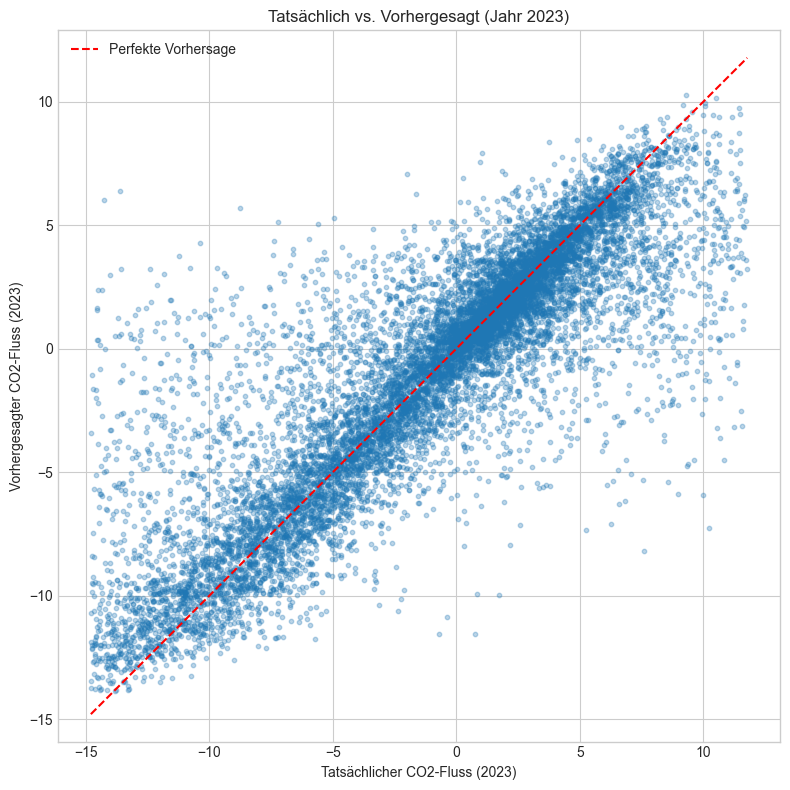

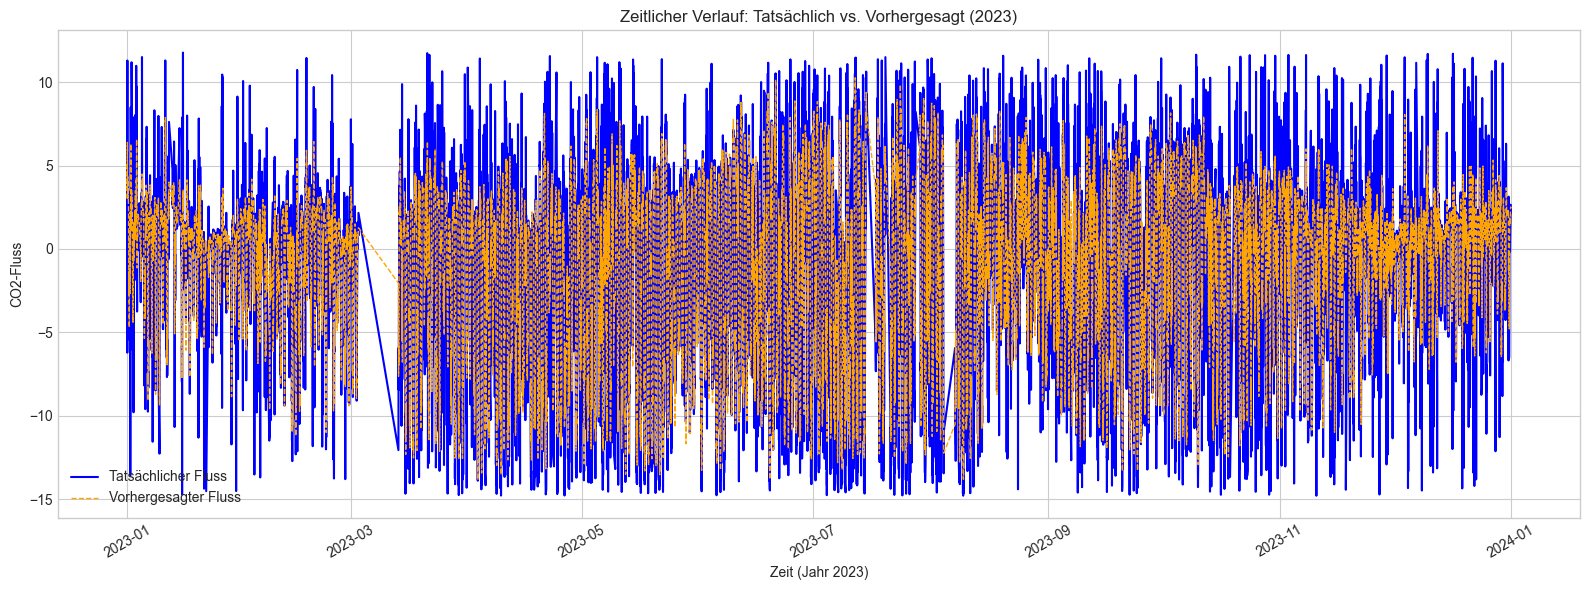

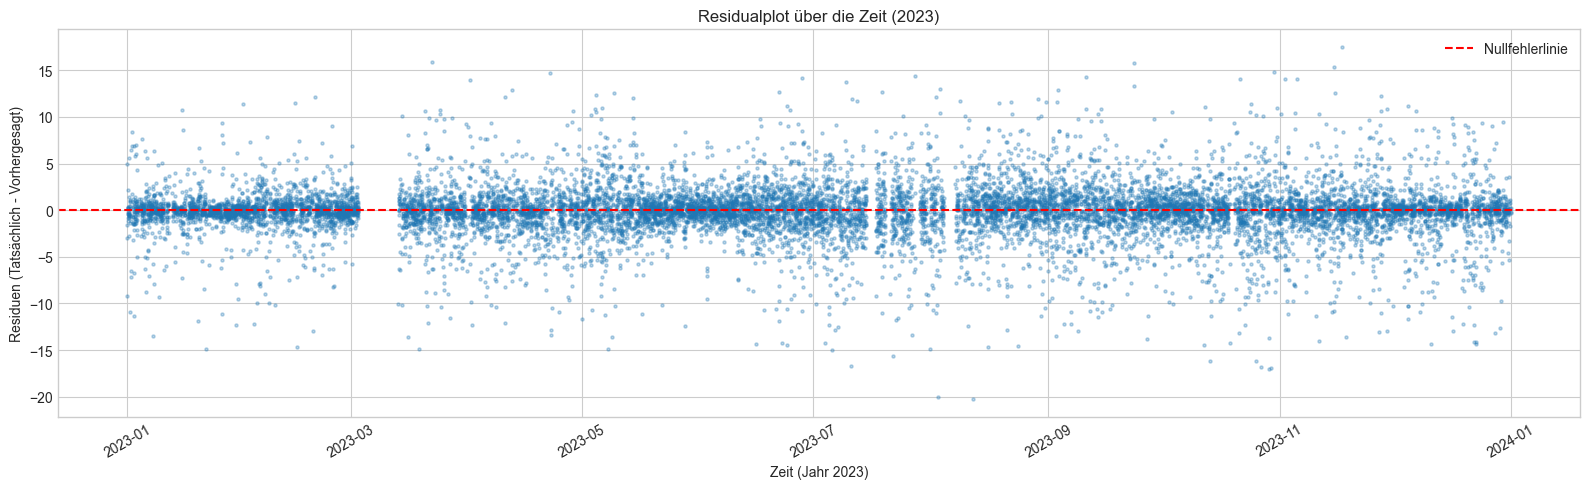


--- Deskriptive Statistiken Tag/Nacht (Jahr 2023) ---

TAG - Tatsächlich:
count    7286.000000
mean       -3.749749
std         5.406476
min       -14.795800
25%        -7.826882
50%        -3.660425
75%         0.183858
max        11.637700
Name: actual_flux, dtype: float64

TAG - Vorhergesagt:
count    7286.000000
mean       -3.644335
std         4.663401
min       -13.847837
25%        -7.314973
50%        -3.498342
75%        -0.077839
max         9.480939
Name: predicted_flux, dtype: float64

NACHT - Tatsächlich:
count    6292.000000
mean        2.432666
std         3.873330
min       -14.799400
25%         0.927531
50%         2.406335
75%         4.577142
max        11.775000
Name: actual_flux, dtype: float64

NACHT - Vorhergesagt:
count    6292.000000
mean        2.503824
std         2.412391
min        -7.539002
25%         1.013258
50%         2.324771
75%         3.962374
max        10.261346
Name: predicted_flux, dtype: float64
----------------------------------------


/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_9250/2494705400.py:196: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_day', y='actual_flux', data=analysis_2023_df, palette=['blue', 'orange'])
/var/folders/34/7g6dz_y96w9c5dg2yhd7tql40000gn/T/ipykernel_9250/2494705400.py:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_day', y='predicted_flux', data=analysis_2023_df, palette=['blue', 'orange'])


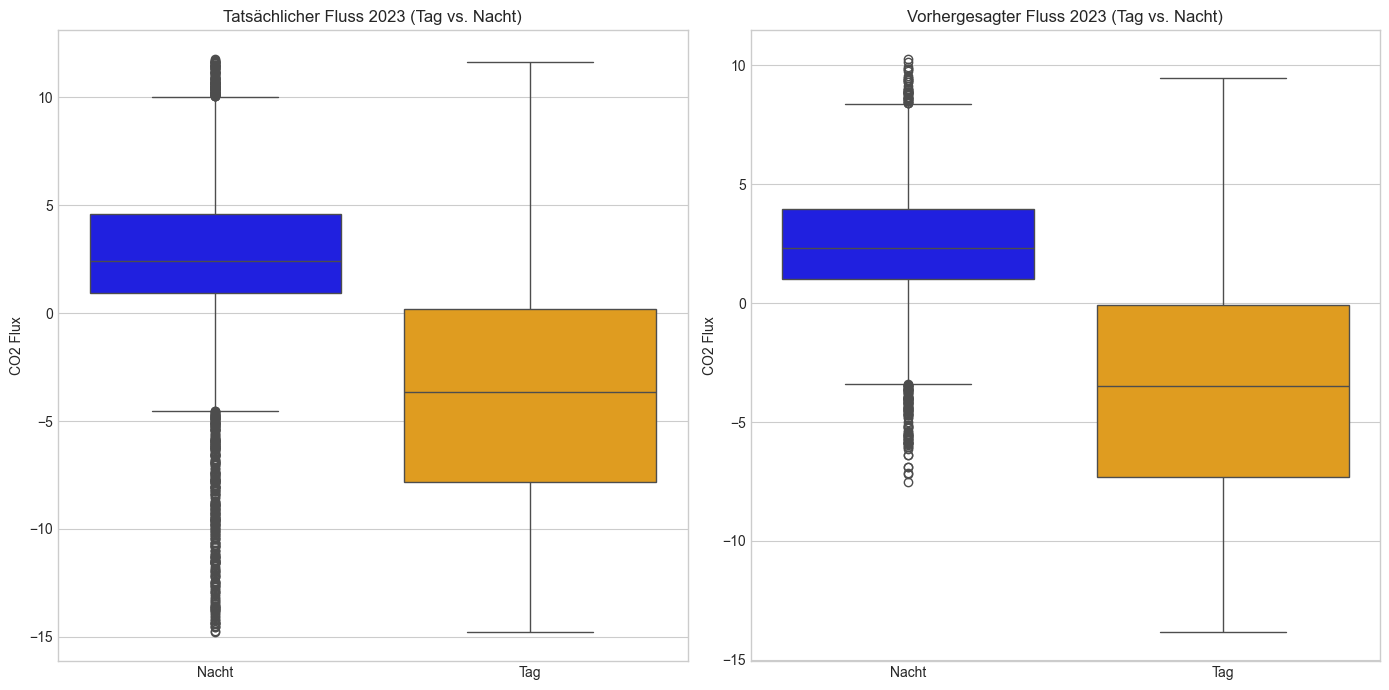

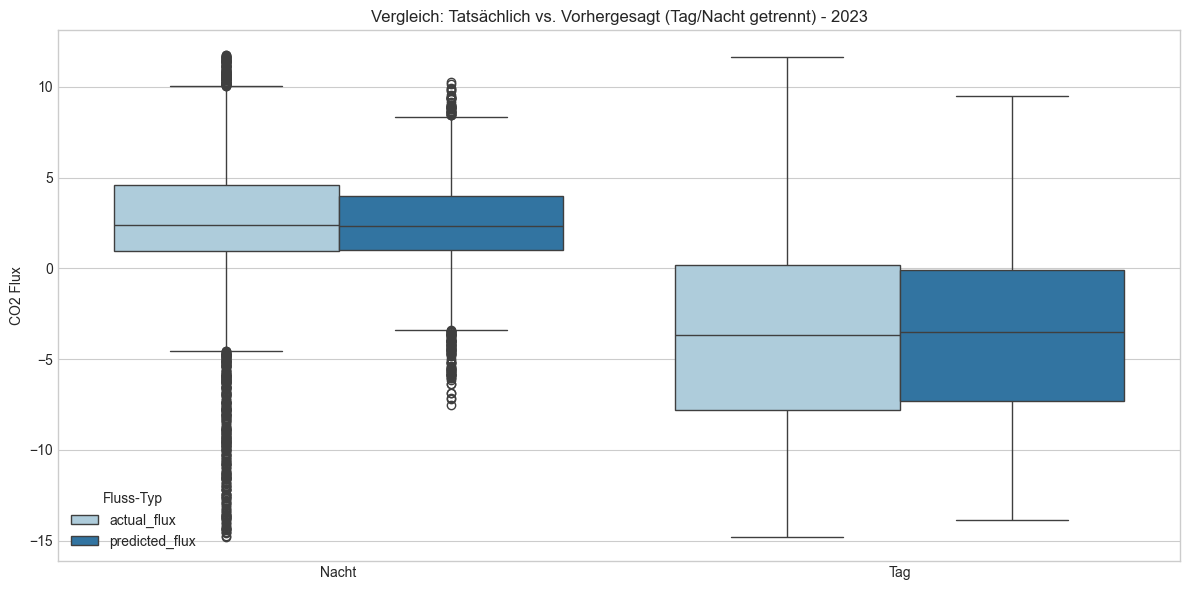

In [12]:
import numpy as np
import pandas as pd
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor # Nur zur Typsicherheit, sollte geladen sein
from sklearn.metrics import mean_squared_error, r2_score
# Falls noch nicht importiert aus dem vorherigen Skript
import joblib
from datetime import datetime

# --- Annahmen: Folgende Variablen aus Ihrem Code sind verfügbar ---
# logger: Der konfigurierte Logger
# best_rf: Das beste trainierte RandomForestRegressor Modell (von GridSearchCV)
# flux_df: Das *vollständige* DataFrame NACH Feature Engineering und dropna(),
#          das die Daten für 2023 enthält.
# features: Die Liste der Feature-Namen, die für das Training verwendet wurden.
# --------------------------------------------------------------------

logger.info("Starte vollständige Modellauswertung für das Jahr 2023...")

# ------------------------------
# 1. Daten für 2023 isolieren
# ------------------------------
try:
    # Stellen Sie sicher, dass der Index ein DatetimeIndex ist
    if not isinstance(flux_df.index, pd.DatetimeIndex):
        flux_df.index = pd.to_datetime(flux_df.index)
        logger.warning("DataFrame-Index wurde in DatetimeIndex konvertiert.")

    flux_2023_df = flux_df[flux_df.index.year == 2023].copy()

    if flux_2023_df.empty:
        logger.error("Keine Daten für das Jahr 2023 im DataFrame gefunden!")
        raise ValueError("Keine 2023 Daten verfügbar.")
    else:
        logger.info(f"Daten für 2023 erfolgreich isoliert. Anzahl Zeilen: {len(flux_2023_df)}")

except Exception as e:
    logger.error(f"Fehler beim Isolieren der 2023 Daten: {e}")
    # Hier ggf. Skript beenden oder Fehler behandeln
    raise

# -----------------------------------------
# 2. Features und Zielvariable für 2023
# -----------------------------------------
# WICHTIG: Für die Auswertung auf historischen Daten verwenden wir die ECHTEN Werte
# für ALLE Features, einschließlich der Lag/Rolling-Features, die aus den ECHTEN
# vergangenen co2_flux_filled Werten berechnet wurden.

try:
    X_2023 = flux_2023_df[features]
    y_2023_actual = flux_2023_df['co2_flux_filled']
    logger.info("Features (X_2023) und tatsächliche Zielvariable (y_2023_actual) für 2023 extrahiert.")

    # Erneute Prüfung auf NaNs (sollte nicht passieren, wenn dropna() vorher global war)
    if X_2023.isnull().any().any():
        logger.warning("NaN-Werte in X_2023 gefunden! Überprüfen Sie das Feature Engineering.")
        # Ggf. hier nochmals behandeln, z.B. X_2023.fillna(method='ffill', inplace=True)
        # oder das Skript abbrechen.

except KeyError as e:
    logger.error(f"Fehler: Feature '{e}' nicht in den 2023 Daten gefunden!")
    raise
except Exception as e:
    logger.error(f"Fehler beim Extrahieren von Features/Zielvariable für 2023: {e}")
    raise

# -----------------------------------------
# 3. Vorhersagen für 2023 generieren
# -----------------------------------------
logger.info("Generiere Modellvorhersagen für 2023...")
try:
    # Stellen Sie sicher, dass das Modell geladen/verfügbar ist
    if 'best_rf' not in globals():
         # Versuchen, das neueste Modell zu laden (Passen Sie den Pfad/Namen an)
         # model_filename = "best_random_forest_model_YYYYMMDD_HHMMSS.joblib" # ERSETZEN
         # best_rf = joblib.load(model_filename)
         # logger.info(f"Modell aus {model_filename} geladen.")
         raise NameError("Variable 'best_rf' (trainiertes Modell) nicht gefunden.")

    y_2023_pred = best_rf.predict(X_2023)
    logger.info("Vorhersagen (y_2023_pred) für 2023 erfolgreich generiert.")

except Exception as e:
    logger.error(f"Fehler bei der Vorhersage für 2023: {e}")
    raise

# -----------------------------------------
# 4. Metriken berechnen und ausgeben
# -----------------------------------------
logger.info("Berechne Evaluationsmetriken für 2023...")

mse_2023 = mean_squared_error(y_2023_actual, y_2023_pred)
rmse_2023 = np.sqrt(mse_2023)
r2_2023 = r2_score(y_2023_actual, y_2023_pred)

print("\n--- Modellauswertung für das Jahr 2023 ---")
print(f"Mean Squared Error (MSE): {mse_2023:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_2023:.4f}")
print(f"R² Score: {r2_2023:.4f}")
print("-" * 40)
logger.info(f"Metriken für 2023: MSE={mse_2023:.4f}, RMSE={rmse_2023:.4f}, R2={r2_2023:.4f}")

# -----------------------------------------
# 5. Grafische Auswertung für 2023
# -----------------------------------------
logger.info("Erstelle grafische Auswertungen für 2023...")
plt.style.use('seaborn-v0_8-whitegrid')

# 5a. Actual vs. Predicted Scatter Plot
plt.figure(figsize=(8, 8))
plt.scatter(y_2023_actual, y_2023_pred, alpha=0.3, s=10)
min_val = min(y_2023_actual.min(), y_2023_pred.min())
max_val = max(y_2023_actual.max(), y_2023_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], '--', color='red', label='Perfekte Vorhersage')
plt.xlabel("Tatsächlicher CO2-Fluss (2023)")
plt.ylabel("Vorhergesagter CO2-Fluss (2023)")
plt.title("Tatsächlich vs. Vorhergesagt (Jahr 2023)")
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.savefig("evaluation_2023_actual_vs_predicted.png")
logger.info("Plot 'evaluation_2023_actual_vs_predicted.png' gespeichert.")
plt.show()

# 5b. Zeitreihenvergleich
plt.figure(figsize=(16, 6))
plt.plot(y_2023_actual.index, y_2023_actual, label='Tatsächlicher Fluss', color='blue', linewidth=1.5)
plt.plot(y_2023_actual.index, y_2023_pred, label='Vorhergesagter Fluss', color='orange', linestyle='--', linewidth=1)
plt.xlabel("Zeit (Jahr 2023)")
plt.ylabel("CO2-Fluss")
plt.title("Zeitlicher Verlauf: Tatsächlich vs. Vorhergesagt (2023)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("evaluation_2023_timeseries.png")
logger.info("Plot 'evaluation_2023_timeseries.png' gespeichert.")
plt.show()

# 5c. Residualplot
residuals_2023 = y_2023_actual - y_2023_pred
plt.figure(figsize=(16, 5))
plt.scatter(y_2023_actual.index, residuals_2023, alpha=0.3, s=5)
plt.axhline(0, color='red', linestyle='--', label='Nullfehlerlinie')
plt.xlabel("Zeit (Jahr 2023)")
plt.ylabel("Residuen (Tatsächlich - Vorhergesagt)")
plt.title("Residualplot über die Zeit (2023)")
plt.grid(True)
plt.legend()
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("evaluation_2023_residuals.png")
logger.info("Plot 'evaluation_2023_residuals.png' gespeichert.")
plt.show()

# -----------------------------------------
# 6. Tag/Nacht Analyse für 2023
# -----------------------------------------
logger.info("Starte Tag/Nacht-Analyse für 2023...")

# Erstelle ein Analyse-DataFrame
analysis_2023_df = pd.DataFrame({
    'actual_flux': y_2023_actual,
    'predicted_flux': y_2023_pred,
    'is_day': X_2023['is_day'] # 'is_day' aus den Features für 2023 holen
}, index=y_2023_actual.index)

# Aufteilen nach Tag/Nacht
actual_day_2023 = analysis_2023_df[analysis_2023_df['is_day'] == 1]['actual_flux']
actual_night_2023 = analysis_2023_df[analysis_2023_df['is_day'] == 0]['actual_flux']
predicted_day_2023 = analysis_2023_df[analysis_2023_df['is_day'] == 1]['predicted_flux']
predicted_night_2023 = analysis_2023_df[analysis_2023_df['is_day'] == 0]['predicted_flux']

logger.info(f"Daten für Tag/Nacht-Analyse vorbereitet. Anzahl Tag: {len(actual_day_2023)}, Nacht: {len(actual_night_2023)}")

# 6a. Deskriptive Statistiken Tag/Nacht
print("\n--- Deskriptive Statistiken Tag/Nacht (Jahr 2023) ---")
print("\nTAG - Tatsächlich:")
print(actual_day_2023.describe())
print("\nTAG - Vorhergesagt:")
print(predicted_day_2023.describe())
print("\nNACHT - Tatsächlich:")
print(actual_night_2023.describe())
print("\nNACHT - Vorhergesagt:")
print(predicted_night_2023.describe())
print("-" * 40)

# 6b. Vergleichende Boxplots Tag/Nacht
plt.figure(figsize=(14, 7))

# Vergleich: Tatsächlich Tag vs. Nacht
plt.subplot(1, 2, 1)
sns.boxplot(x='is_day', y='actual_flux', data=analysis_2023_df, palette=['blue', 'orange'])
plt.title('Tatsächlicher Fluss 2023 (Tag vs. Nacht)')
plt.xlabel('')
plt.ylabel('CO2 Flux')
plt.xticks([0, 1], ['Nacht', 'Tag'])

# Vergleich: Vorhergesagt Tag vs. Nacht
plt.subplot(1, 2, 2)
sns.boxplot(x='is_day', y='predicted_flux', data=analysis_2023_df, palette=['blue', 'orange'])
plt.title('Vorhergesagter Fluss 2023 (Tag vs. Nacht)')
plt.xlabel('')
plt.ylabel('CO2 Flux')
plt.xticks([0, 1], ['Nacht', 'Tag'])

plt.tight_layout()
plt.savefig("evaluation_2023_daynight_comparison_boxplot.png")
logger.info("Plot 'evaluation_2023_daynight_comparison_boxplot.png' gespeichert.")
plt.show()

# Optional: Direkter Vergleich Actual vs Predicted für Tag und Nacht getrennt
analysis_2023_df_melt = analysis_2023_df.melt(id_vars=['is_day'],
                                              value_vars=['actual_flux', 'predicted_flux'],
                                              var_name='Flux_Type', value_name='CO2_Flux')

plt.figure(figsize=(12, 6))
sns.boxplot(x='is_day', y='CO2_Flux', hue='Flux_Type', data=analysis_2023_df_melt, palette="Paired")
plt.title('Vergleich: Tatsächlich vs. Vorhergesagt (Tag/Nacht getrennt) - 2023')
plt.xlabel('')
plt.ylabel('CO2 Flux')
plt.xticks([0, 1], ['Nacht', 'Tag'])
plt.legend(title='Fluss-Typ')
plt.tight_layout()
plt.savefig("evaluation_2023_daynight_detailed_boxplot.png")
logger.info("Plot 'evaluation_2023_daynight_detailed_boxplot.png' gespeichert.")
plt.show()


logger.info("Vollständige Modellauswertung für 2023 abgeschlossen.")